# Showcase I: Creating coverage tiler + Output Visualization in an interactive map

<div class="alert alert-block alert-info">  
<font size=3.5><strong>Section 2: </strong><br>Explore STAC API + Geopandas inside a Jupyter notebook to compute spatial intersection between STAC collections and use the intersection to make an OGC getmap request.</font> 
</div>

## Step 1:

<div class="alert alert-block alert-success">
Import Modules:
<li>fiona: read and write reads and writes spatial data files</li>
<li>shapely: manipulation and analysis of planar geometric objects</li>
<li>geopandas: spatial operations on geometric types</li>
<li>matplotlib: create static, animated, and interactive visualizations</li>
</div>

In [6]:
import matplotlib.pyplot as plt
import json
from shapely.geometry import Polygon, shape, box, mapping
import geopandas as gpd
from shapely import wkt
from shapely.geometry import box
from shapely.ops import transform
import pyproj

## Step 2:

<div class="alert alert-block alert-success">
Read the Salish collection from STAC API and create a geoDataFrame based on the geojson
</div>

In [2]:
# url of the Salish collection
url = "https://datacube.services.geo.ca/api/search?collections=salish"

# create a geodataframe
gdf = gpd.read_file(url)
print(gdf)

            id   gsd                   datetime collection  \
0  salish-1950  0.25  1950-01-01T00:00:00+00:00     salish   
1  salish-1959   0.5  1959-01-01T00:00:00+00:00     salish   
2  salish-1967   0.5  1967-01-01T00:00:00+00:00     salish   
3  salish-1972   0.5  1972-01-01T00:00:00+00:00     salish   
4  salish-1978   0.5  1978-01-01T00:00:00+00:00     salish   
5  salish-1982   0.7  1982-01-01T00:00:00+00:00     salish   

                                            geometry  
0  POLYGON ((-123.29531 49.14178, -122.78618 49.1...  
1  POLYGON ((-123.55737 49.09842, -122.38712 49.0...  
2  POLYGON ((-123.44615 49.00821, -122.42590 49.0...  
3  POLYGON ((-123.31921 49.22520, -122.80963 49.2...  
4  POLYGON ((-123.44380 49.15707, -122.28672 49.1...  
5  POLYGON ((-123.31661 49.02470, -122.39550 49.0...  


## Step 3:

<div class="alert alert-block alert-success">
Extract all geometries as well as their ids and form a list of geometry
</div>

In [3]:
geom = gdf.geometry
matrix = []
# create a list of id and geometry for all the polygons
for i in range(len(gdf)):
    cur_geom = {'id':[gdf.id[i]], 'geometry':shape(geom[i])}
    cur_gdf = gpd.GeoDataFrame(cur_geom, crs = "EPSG:4326")
    matrix.append(cur_gdf)
print(matrix)

[            id                                           geometry
0  salish-1950  POLYGON ((-123.29531 49.14178, -122.78618 49.1...,             id                                           geometry
0  salish-1959  POLYGON ((-123.55737 49.09842, -122.38712 49.0...,             id                                           geometry
0  salish-1967  POLYGON ((-123.44615 49.00821, -122.42590 49.0...,             id                                           geometry
0  salish-1972  POLYGON ((-123.31921 49.22520, -122.80963 49.2...,             id                                           geometry
0  salish-1978  POLYGON ((-123.44380 49.15707, -122.28672 49.1...,             id                                           geometry
0  salish-1982  POLYGON ((-123.31661 49.02470, -122.39550 49.0...]


## Step 4:

<div class="alert alert-block alert-success">
Find the intersection of all geometries in the Salish collection and visualize it using matplotlib 
</div>

<function matplotlib.pyplot.show(close=None, block=None)>

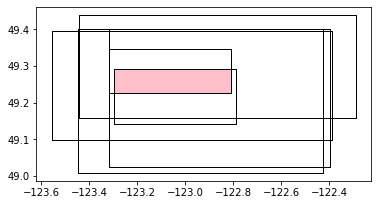

In [4]:
result=[]
result.append(gpd.overlay(matrix[0],matrix[1],how='intersection'))
for i in range (0,len(matrix)-2,1):
    cur = gpd.overlay(result[i],matrix[i+2], how='intersection')
    result.append(cur)
#take the last result
final = result[-1]
print(final)

ax = final.plot(color='pink')
for i in range(0,len(matrix),1):
    matrix[i].plot(ax=ax, facecolor='None', edgecolor='k');
plt.show

## Step 5
<div class="alert alert-block alert-success">
Reproject the tilings to the same coordinate system of basemap and convert it into a geodataframe
</div>

In [8]:
bound_box = box(*final.total_bounds)
project = pyproj.Transformer.from_proj(
    pyproj.Proj('epsg:4326'),
    pyproj.Proj('epsg:32610'),
    always_xy=True) # destination coordinate system

proj_test = transform(project.transform, bound_box)  # apply projection
print(proj_test.bounds)

(478498.0729313628, 5452507.645790464, 513861.29575948894, 5459789.683238143)


## Step 6
<div class="alert alert-block alert-success">
Use this intersection polygon as bbox and time range to pass a getmap request to the OGC WMS server parameters include:
<li>bbox: polygon extent</li>
<li>time: the datatime range</li>
<li>crs: an acceptable coordinage reference system that is listed in the getcapabilities and matches the coordinates of the bbox</li>
    <br>
    <strong>Example link: </strong><p style='text-decoration:underline;'>https://datacube.services.geo.ca/ows/aerial?service=wms&request=GetMap&styles=&format=image/jpeg&layers=salish&version=1.3&height=732&width=982&bbox=-122.4,49.1,-122.2,49.2&crs=EPSG:4326&TIME=1950-01-01T00:00:00Z/1982-01-01T00:00:00Z&transparent=true</p>
</div>

In [11]:
minx = final.total_bounds[0]
miny = final.total_bounds[1]
maxx = final.total_bounds[2]
maxy = final.total_bounds[3]
new_bbox = [miny,minx,maxy,maxx]
start = gdf.datetime[0]
end = gdf.datetime[len(gdf)-1]
crs = gdf.crs
def getUrl(collection='salish',parameter='datacube',value='notset',start_date=start,end_date=end,width='732',height='982'):
    layers='salish'
    crs="EPSG:4326"
    x = ""+ str(miny) + ',' + str(minx) + ',' + str(maxy) + ',' + str(maxx) 
    url = "https://datacube.services.geo.ca/ows/aerial?service=wms&request=GetMap&styles=&format=image/png"
    url+="&LAYERS=%s&WIDTH=%s&HEIGHT=%s&CRS=%s&"%(layers,width,height,crs)
    
    url+="BBOX=%s"%(x)
    url+="&TIME=%sT12:00:00Z/%sT12:00:00Z"%(start_date,end_date)
    url+="&%s=%s"%(parameter,value)
    return url
url=getUrl(collection='salish',parameter='datacube',
                       value='notset',start_date=start,
                       end_date=end,width='732',height='982')
print(url)

https://datacube.services.geo.ca/ows/aerial?service=wms&request=GetMap&styles=&format=image/png&LAYERS=salish&WIDTH=732&HEIGHT=982&CRS=EPSG:4326&BBOX=49.225195681615254,-123.29530682511599,49.29047868957142,-122.8096294492051&TIME=1950-01-01T00:00:00+00:00T12:00:00Z/1982-01-01T00:00:00+00:00T12:00:00Z&datacube=notset
